### Syscoin 4.0 Research: Modeling Gas Fees for ETH
* Model of ETH Gas costs
    * Baysian inference using Gaussian Processes
    * General Mixture models
    * Kernel Density Estimator
* https://www.cs.toronto.edu/~duvenaud/cookbook/
* https://docs.pymc.io/notebooks/GP-MeansAndCovs.html
* https://etherscan.io/chart/gasprice
* https://etherchain.org/charts
* https://coinmarketcap.com/alexandria/glossary/gas-price
* https://ethresear.ch/t/first-and-second-price-auctions-and-improved-transaction-fee-markets/2410

In [1]:
#!pip3 install pomegranate==0.12.0
#!pip3 install pymc3==3.10.0
#!pip3 install ArviZ==0.11.0

In [2]:
import pymc3 as pm
import pandas as pd
import numpy as np
import theano.tensor as tt
import random
import datetime
import matplotlib.pyplot as plt

from pomegranate import *
from matplotlib import pyplot
from numpy.random import normal
from numpy import hstack
from numpy import asarray
from numpy import exp
from sklearn.neighbors import KernelDensity

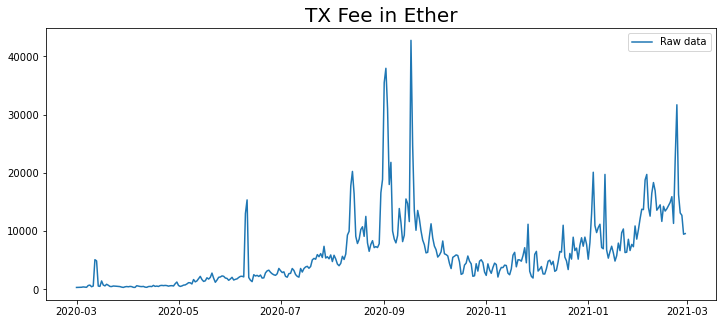

In [3]:
tx_fee = pd.read_csv('../resources/TransactionFee.csv')
tx_fee.columns = ['date', 'timestamp','tx_fee']
tx_fee = tx_fee.assign(tx_fee = [float(tx)/1e18 for tx in tx_fee['tx_fee'].values])

eth_price = pd.read_csv('../resources/EtherPrice.csv')
eth_price.columns = ['date', 'timestamp','price_val']
gas_used = pd.read_csv('../resources/GasUsed.csv')
gas_used.columns = ['date', 'timestamp','gas_val']
tx_growth = pd.read_csv('../resources/TxGrowth.csv')
tx_growth.columns = ['date', 'timestamp','tx_val']

gas_price = pd.read_csv('../resources/AvgGasPrice.csv')
gas_price.columns = ['date', 'timestamp','eth']
gas_price = gas_price.assign(eth = gas_price['eth'].values/1e18)

date_split = [t.rstrip().split('/') for t in tx_fee['date'].values]
date_times = [datetime.date(int(t[2]), int(t[0]), int(t[1])) for t in date_split]
tx_fee = tx_fee.assign(date_time = date_times)

tx_fee = tx_fee[['date','date_time','timestamp','tx_fee']]
tx_fee = tx_fee.tail(365).copy()
tx_fee.reset_index(drop=True, inplace=True)

upr_q = float(tx_fee[['tx_fee']].quantile(0.99))
indices = list(np.argwhere(tx_fee['tx_fee'].values > upr_q).flatten())
tx_fee.loc[indices,'gwei'] = np.nan
tx_fee['gwei'] = tx_fee['tx_fee'].interpolate(method='polynomial', order=2, axis=0)

plt.figure(figsize=(12,5))
plt.plot(tx_fee['date_time'].values, tx_fee['tx_fee'].values, label="Raw data")
plt.title("TX Fee in Ether", fontsize=20)
plt.legend();

In [4]:
gas_price = pd.read_csv('../resources/AvgGasPrice.csv')
gas_price.columns = ['date', 'timestamp','wei']
gas_price.head(5)

,date,timestamp,wei
0,7/30/2015,1438214400,0
1,7/31/2015,1438300800,0
2,8/1/2015,1438387200,0
3,8/2/2015,1438473600,0
4,8/3/2015,1438560000,0


In [5]:
date_split = [t.rstrip().split('/') for t in gas_price['date'].values]
date_times = [datetime.date(int(t[2]), int(t[0]), int(t[1])) for t in date_split]
gas_price = gas_price.assign(date_time = date_times)
gas_price = gas_price.assign(gwei = gas_price['wei'].values/1e9)
gas_price = gas_price.assign(yr = [t.year for t in gas_price['date_time'].values])
gas_price = gas_price[['date','date_time','timestamp','yr','wei','gwei']]

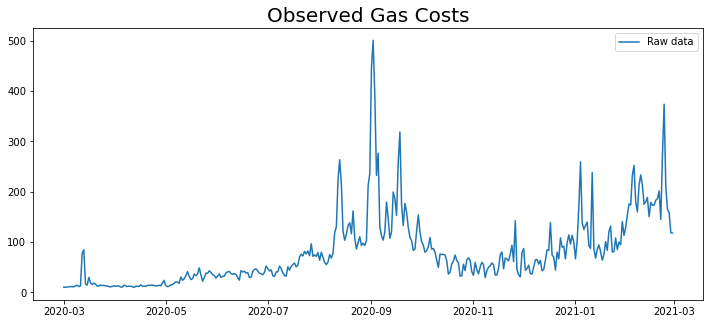

In [6]:
#plt_gas_price = gas_price[(gas_price.yr == 2020) | (gas_price.yr == 2021)].copy()
plt_gas_price = gas_price.tail(365).copy()
plt_gas_price = plt_gas_price.assign(tx_fee = tx_fee['tx_fee'].values)
plt_gas_price = plt_gas_price.assign(num_tx = tx_growth['tx_val'].tail(365).values)
plt_gas_price.reset_index(drop=True, inplace=True)

upr_q = float(plt_gas_price[['gwei']].quantile(0.99))
indices = list(np.argwhere(plt_gas_price['gwei'].values > upr_q).flatten())
plt_gas_price.loc[indices,'gwei'] = np.nan
plt_gas_price['gwei'] = plt_gas_price['gwei'].interpolate(method='polynomial', order=2, axis=0)

plt.figure(figsize=(12,5))
plt.plot(plt_gas_price['date_time'].values, plt_gas_price['gwei'].values, label="Raw data")
plt.title("Observed Gas Costs", fontsize=20)
N = len(plt_gas_price['date_time'].values)
plt.legend();

In [7]:
from sklearn.linear_model import LinearRegression

plt_tx_gas = plt_gas_price.sort_values(by=['tx_fee']).copy()
plt_tx_gas.reset_index(drop=True, inplace=True)

y = plt_tx_gas['gwei'].values

mu=np.empty(len(plt_tx_gas))
mu.fill(1)
mu = mu.reshape(-1,1)
X = np.hstack((mu,plt_tx_gas['tx_fee'].values.reshape(-1,1)))
reg = LinearRegression().fit(X, y)
pred = reg.predict(X)

resid = np.abs(y - pred)
upr_q = np.quantile(resid,0.99)
indices = list(np.argwhere(resid > 100).flatten())

plt_tx_gas.loc[indices,'gwei'] = np.nan
plt_tx_gas['gwei'] = plt_tx_gas['gwei'].interpolate(method='polynomial', order=2, axis=0)
y[364] = y[363]

X = np.hstack((mu,plt_tx_gas['tx_fee'].values.reshape(-1,1)))
reg = LinearRegression().fit(X, y)
pred = reg.predict(X)

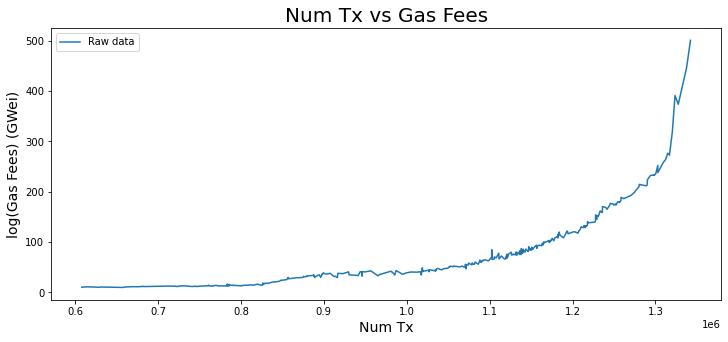

In [8]:
plt_price_auction = plt_gas_price.sort_values(by=['num_tx']).copy()
plt.figure(figsize=(12,5))
plt.plot(plt_price_auction['num_tx'].values[:-1], plt_tx_gas['gwei'].values[:-1], label="Raw data")
plt.title("Num Tx vs Gas Fees", fontsize=20)
plt.ylabel("log(Gas Fees) (GWei)", fontsize=14)
plt.xlabel("Num Tx", fontsize=14)
plt.legend();

In [32]:
N = len(plt_price_auction['date_time'].values)
X = plt_price_auction['num_tx'].values[:-1].reshape(-1,1)
y = np.log(plt_tx_gas['gwei'].values[:-1])

In [33]:
with pm.Model() as model:
    
    η = pm.HalfNormal("η", sigma=5)
    ℓ = pm.Gamma("ℓ", alpha=4, beta=2)
    α = pm.Gamma("α", alpha=0.5, beta=1)
    cov = η ** 2 * pm.gp.cov.RatQuad(1, α, ℓ)      
    
    #ℓ = pm.Gamma("ℓ", alpha=2, beta=1)
    #η = pm.HalfCauchy("η", beta=5)
    #cov = η ** 2 * pm.gp.cov.Matern52(1, ℓ)
    
    gp = pm.gp.Marginal(cov_func=cov)

    σ = pm.HalfCauchy("σ", beta=5)
    y_ = gp.marginal_likelihood("y", X=X, y=y, noise=σ)

    mp = pm.find_MAP()

In [34]:
# new values from x=0 to x=20
X_new = np.linspace(600000, 1300000, N-1)[:, None]

# add the GP conditional to the model, given the new X values
with model:
    f_pred = gp.conditional("f_pred", X_new)

# To use the MAP values, you can just replace the trace with a length-1 list with `mp`
with model:
    pred_samples = pm.sample_posterior_predictive([mp], vars=[f_pred], samples=2000)

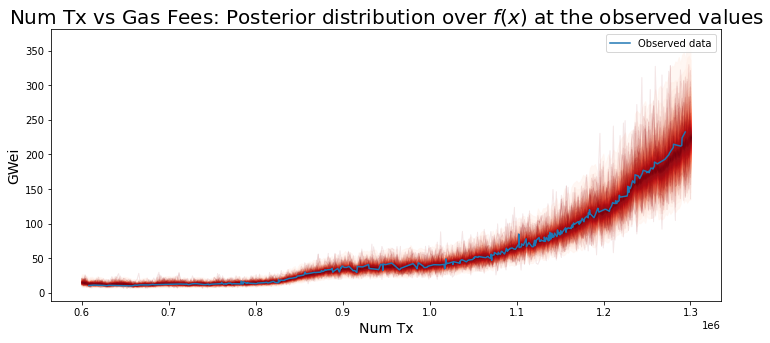

In [41]:
# plot the results
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist

plot_gp_dist(ax, np.exp(pred_samples["f_pred"]), X_new)

# plot the data and the true latent function
plt.plot(X[0:350], np.exp(y[0:350]), alpha=1, label="Observed data")
#plt.plot(X_new, np.exp(y), alpha=0.5, label="Observed data")

# axis labels and title
plt.ylabel("GWei", fontsize=14)
plt.xlabel("Num Tx", fontsize=14)
plt.title("Num Tx vs Gas Fees: Posterior distribution over $f(x)$ at the observed values", fontsize=20)
plt.legend();

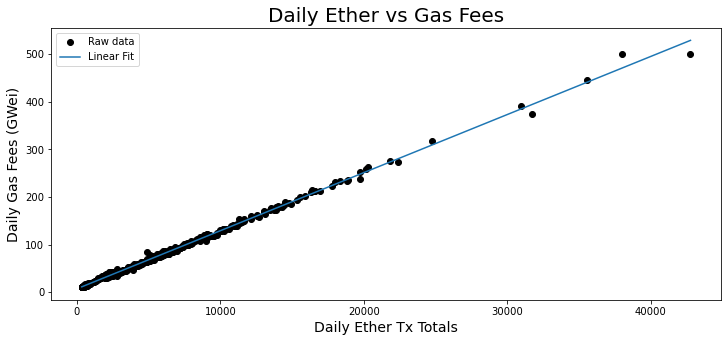

In [13]:
plt.figure(figsize=(12,5))
plt.plot(plt_tx_gas['tx_fee'].values, plt_tx_gas['gwei'].values, "ok", label="Raw data")
plt.plot(plt_tx_gas['tx_fee'].values, pred, label="Linear Fit")
plt.title("Daily Ether vs Gas Fees", fontsize=20)
plt.ylabel("Daily Gas Fees (GWei)", fontsize=14)
plt.xlabel("Daily Ether Tx Totals", fontsize=14)
plt.legend();

In [14]:
N = len(plt_gas_price['date_time'].values)
X = np.linspace(0, N-1, N)[:, None]
y = plt_gas_price['gwei'].values

In [15]:
with pm.Model() as model:
    
    η = pm.HalfNormal("η", sigma=5)
    ℓ = pm.Gamma("ℓ", alpha=4, beta=2)
    α = pm.Gamma("α", alpha=0.5, beta=1)
    cov = η ** 2 * pm.gp.cov.RatQuad(1, α, ℓ)      
    
    #ℓ = pm.Gamma("ℓ", alpha=2, beta=1)
    #η = pm.HalfCauchy("η", beta=5)
    #cov = η ** 2 * pm.gp.cov.Matern52(1, ℓ)
    
    gp = pm.gp.Marginal(cov_func=cov)

    σ = pm.HalfCauchy("σ", beta=5)
    y_ = gp.marginal_likelihood("y", X=X, y=y, noise=σ)

    mp = pm.find_MAP()

In [16]:
# new values from x=0 to x=20
X_new = np.linspace(0, N-1, N)[:, None]

# add the GP conditional to the model, given the new X values
with model:
    f_pred = gp.conditional("f_pred", X_new)

# To use the MAP values, you can just replace the trace with a length-1 list with `mp`
with model:
    pred_samples = pm.sample_posterior_predictive([mp], vars=[f_pred], samples=2000)

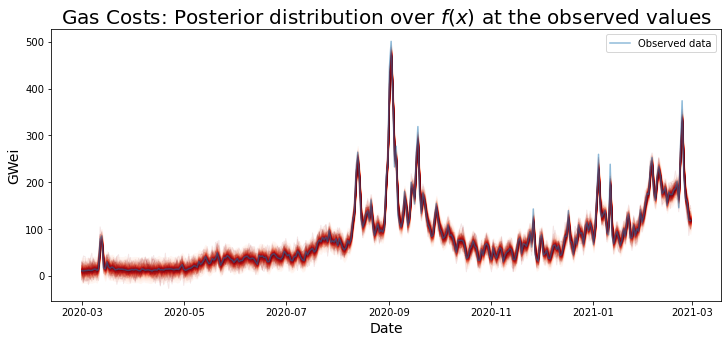

In [17]:
# plot the results
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

dates = plt_gas_price['date_time'].values.reshape(-1,1)

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist

plot_gp_dist(ax, pred_samples["f_pred"], dates)

# plot the data and the true latent function
plt.plot(dates, y, alpha=0.5, label="Observed data")

# axis labels and title
plt.ylabel("GWei", fontsize=14)
plt.xlabel("Date", fontsize=14)
plt.title("Gas Costs: Posterior distribution over $f(x)$ at the observed values", fontsize=20)
plt.legend();

fig.savefig('../img/gas_costs_posterior.png')

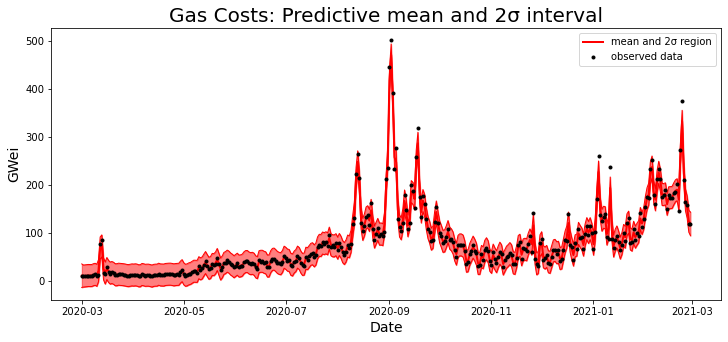

In [18]:
mu, var = gp.predict(X_new, point=mp, diag=True)
sd = np.sqrt(var)

# draw plot
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# plot mean and 2σ intervals
plt.plot(dates, mu, "r", lw=2, label="mean and 2σ region")
plt.plot(dates, mu + 2 * sd, "r", lw=1)
plt.plot(dates, mu - 2 * sd, "r", lw=1)
plt.fill_between(dates.flatten(), mu - 2 * sd, mu + 2 * sd, color="r", alpha=0.5)

# plot original data and true function
plt.plot(dates, y, "ok", ms=3, alpha=1.0, label="observed data")
plt.ylabel("GWei", fontsize=14)
plt.xlabel("Date", fontsize=14)
plt.title("Gas Costs: Predictive mean and 2σ interval", fontsize=20)
plt.legend();

fig.savefig('../img/gas_costs_pred.png')

In [19]:
# fit density
pSample = pred_samples["f_pred"].flatten()
pSample = pSample[pSample > 0]

nSample = int(0.2*len(pred_samples["f_pred"].flatten()))
sample = np.array(random.sample(list(pSample), nSample)).reshape(-1,1)

sample = pSample.reshape(-1,1)
#sample = y.reshape(-1,1)

kde_model = KernelDensity(bandwidth=2, kernel='gaussian')
kde_model.fit(sample)

values = asarray([value for value in range(0, 400)])
values = values.reshape((len(values), 1))

gamma_model = GammaDistribution.from_samples(sample)
gamma_fit = gamma_model.probability(values[:].flatten())

gmm_model = GeneralMixtureModel.from_samples(GammaDistribution, 3, sample)
gmm_fit = gmm_model.probability(values[:].flatten())

# sample probabilities for a range of outcomes
probabilities = kde_model.score_samples(values)
kde_fit = exp(probabilities)

In [20]:
print('GWei 50%: {:.1f}'.format(np.quantile(sample.flatten(), 0.5)))
print('GWei 5%: {:.1f}'.format(np.quantile(sample.flatten(), 0.05)))
print('GWei 95%: {:.1f}'.format(np.quantile(sample.flatten(), 0.95)))

GWei 50%: 62.9
GWei 5%: 10.0
GWei 95%: 210.1


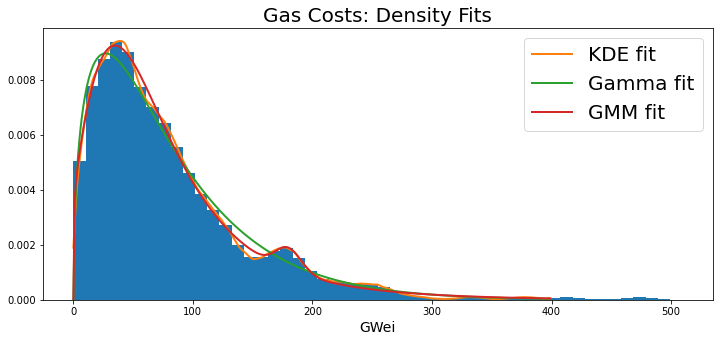

In [21]:
plt.figure(figsize=(12, 5))
plt.hist(sample, bins=50, density=True)
plt.plot(values[:], kde_fit, label="KDE fit", linewidth=2)
plt.plot(values[:], gamma_fit, label="Gamma fit", linewidth=2)
plt.plot(values[:], gmm_fit, label="GMM fit", linewidth=2)
plt.legend(fontsize=20)
plt.xlabel("GWei", fontsize=14)
plt.title("Gas Costs: Density Fits", fontsize=20)
plt.show()
fig.savefig('../img/density_fits.png')

In [22]:
#gas_cost = np.quantile(sample.flatten(), 0.5)
gas_cost = np.quantile(sample.flatten(), 0.95)
#gas_cost = np.quantile(sample.flatten(), 0.05)
wei = 1e18
gwei = 1e9

L1_ETH = 6.3e9*gas_cost*gwei/wei
L2_ETH_ZKRollup = 94.47e6*gas_cost*gwei/wei
L2_ETH_Validium = 5e6*gas_cost*gwei/wei

L1_SYSX = 6.3e9*gas_cost*gwei/wei
L2_SYSX_ZKRollup = 94.47e6*gas_cost*gwei/wei
L2_SYSX_Validium = 5e6*gas_cost*gwei/wei

In [23]:
print('Cost {:.2f} ETH per 300k tx for L1 @ 50th percentile'.format(L1_ETH))
print('Cost {:.2f} ETH per 300k tx for L2 ZK Rollup @ 50th percentile'.format(L2_ETH_ZKRollup))
print('Cost {:.2f} ETH per 300k tx for L2 Validium @ 50th percentile'.format(L2_ETH_Validium))

Cost 1323.81 ETH per 300k tx for L1 @ 50th percentile
Cost 19.85 ETH per 300k tx for L2 ZK Rollup @ 50th percentile
Cost 1.05 ETH per 300k tx for L2 Validium @ 50th percentile


In [24]:
print('Cost {:.8f} ETH per tx for L1 @ 50th percentile'.format(L1_ETH/3e5))
print('Cost {:.8f} ETH per tx for L2 ZK Rollup @ 50th percentile'.format(L2_ETH_ZKRollup/3e5))
print('Cost {:.8f} ETH per tx for L2 Validium @ 50th percentile'.format(L2_ETH_Validium/3e5))

Cost 0.00441271 ETH per tx for L1 @ 50th percentile
Cost 0.00006617 ETH per tx for L2 ZK Rollup @ 50th percentile
Cost 0.00000350 ETH per tx for L2 Validium @ 50th percentile
